---
**Module 1 Final Project Submission**

* Student name: **Ru Keïn**
* Student pace: **Full-Time**
* Project review date/time: **November 4, 2019 at 2:00 PM PST**
* Instructor name: **James Irving, PhD**
* Blog post URL: http://hakkeray.com/blog/predicting-house-prices-using-linear-regression
* Notebook Blog post: www.hakkeray.com/projects/datascience/king-county-housing-data

**GOAL**
* Identify best combination of variable(s) for predicting property values in King County, Washington, USA. 

**OBJECTIVES**
* Address null, missing, duplicate, and unreliable values in the data.
* Determine best approach for analyzing each feature: continuous vs. categorical values
* Identify which combination of features (X) are the best predictors of the target (y). 

**QUESTIONS TO EXPLORE**
* *Scrub*
    * 1. How should we address each feature to prepare it for EDA?
 
* *Explore*
    * 2. Which predictors are closely related (and should be dropped)?
    * 3. Is there an overlap in square-footage measurements?
    * 4. Can we combine two features into one to achieve a higher correlation?
    * 5. Does geography (location) have any relationship with the values of each categorical variable?
 
* *Model*
    * 6. Which features are the best candidates for predicting property values?
    * 7. Does removing outliers improve the distribution?
    * 8. Does scaling/transforming variables improve the regression algorithm?

**TABLE OF CONTENTS**

**[1  OBTAIN]**
Import libraries, packages, data set
* 1.1 Import libraries and packages
* 1.2 Import custom functions
* 1.3 Import dataset and review columns, variables

**[2  SCRUB]**
Clean and organize the data.
* 2.1 Find and replace missing values (nulls)
* 2.2 Identify/Address characteristics of each variable (numeric vs categorical) 
* 2.3 Check for and drop any duplicate observations (rows)
* 2.4 Decide which variables to keep for EDA

**[3  EXPLORE]**
Preliminary analysis and visualizations.
* 3.1 Linearity: Scatterplots, scattermatrix
* 3.2 Multicollinearity: Heatmaps, scatterplots
* 3.3 Distribution: Histograms, Kernel Density Estimates (KDE), LMplots, Boxplots
* 3.4 Regression: regression plots

**[4  MODEL]**
Fit an initial model.
* 4.1 Run OLS Linear Regression Model (Model.1)
* 4.2 Check for residuals, outliers: QQ Plots
* 4.3 Adjust model (remove outliers, vars with high P-values)
* 4.4 Re-run OLS (Model.2)
* 4.5 Scale and Normalize data (RobustScaler), re-run OLS
* 4.6 Perform Feature Selection (Step-wise/Forward Selection)
* 4.7 Re-run OLS for Final Model (Model.3)

**[5  VALIDATION]**
Validate the results.
* 5.1 K-Fold Cross Validation

**[6  CONCLUSION]**
Summarize the findings and make recommendations.
* 6.1 Briefly summarize the results of analysis
* 6.2 Make recommendations
* 6.3 Describe possible future directions

---
# OBTAIN

## Import libraries + packaes

In [1]:
# Import libraries and packages

# import PyPi package for cohort libraries using shortcut
#!pip install -U fsds_100719 # comment out after install so it won't run again
# Import packages
import fsds_100719 as fs
from fsds_100719.imports import *
plt.style.use('fivethirtyeight')
#inline_rc = dict(mpl.rcParams)
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import normaltest as normtest # D'Agostino and Pearson's omnibus test
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
#!pip install uszipcode


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')

# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

fsds_1007219  v0.4.8 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 
> For convenient loading of standard modules use: `>> from fsds_100719.imports import *`



Package,Handle,Description
IPython.display,dp,Display modules with helpful display and clearing commands.
fsds_100719,fs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


## Import custom functions

In [2]:
# HOT_STATS() function: display statistical summaries of a feature column
def hot_stats(data, column, verbose=False, t=None):
    """
    Scans the values of a column within a dataframe and displays its datatype, 
    nulls (incl. pct of total), unique values, non-null value counts, and 
    statistical info (if the datatype is numeric).
    
    ---------------------------------------------
    
    Parameters:
    
    **args:
    
        data: accepts dataframe
    
        column: accepts name of column within dataframe (should be inside quotes '')
    
    **kwargs:
    
        verbose: (optional) accepts a boolean (default=False); verbose=True will display all 
        unique values found.   
    
        t: (optional) accepts column name as target to calculate correlation coefficient against 
        using pandas data.corr() function. 
    
    -------------
    
    Examples: 
    
    hot_stats(df, 'str_column') --> where df = data, 'string_column' = column you want to scan
    
    hot_stats(df, 'numeric_column', t='target') --> where 'target' = column to check correlation value
    
    -----------------
    Developer notes: additional features to add in the future:
    -get mode(s)
    -functionality for string objects
    -pass multiple columns at once and display all
    -----------------
    SAMPLE OUTPUT: 
    ****************************************
    
    -------->
    HOT!STATS
    <--------

    CONDITION
    Data Type: int64

    count    21597.000000
    mean         3.409825
    std          0.650546
    min          1.000000
    25%          3.000000
    50%          3.000000
    75%          4.000000
    max          5.000000
    Name: condition, dtype: float64 

    à-la-Mode: 
    0    3
    dtype: int64


    No Nulls Found!

    Non-Null Value Counts:
    3    14020
    4     5677
    5     1701
    2      170
    1       29
    Name: condition, dtype: int64

    # Unique Values: 5
    
    """
    # assigns variables to call later as shortcuts 
    feature = data[column]
    rdash = "-------->"
    ldash = "<--------"
    
    # figure out which hot_stats to display based on dtype 
    if feature.dtype == 'float':
        hot_stats = feature.describe().round(2)
    elif feature.dtype == 'int':
        hot_stats = feature.describe()
    elif feature.dtype == 'object' or 'category' or 'datetime64[ns]':
        hot_stats = feature.agg(['min','median','max'])
        t = None # ignores corr check for non-numeric dtypes by resetting t
    else:
        hot_stats = None

    # display statistics (returns different info depending on datatype)
    print(rdash)
    print("HOT!STATS")
    print(ldash)
    
    # display column name formatted with underline
    print(f"\n{feature.name.upper()}")
    
    # display the data type
    print(f"Data Type: {feature.dtype}\n")
    
    # display the mode
    print(hot_stats,"\n")
    print(f"à-la-Mode: \n{feature.mode()}\n")
    
    # find nulls and display total count and percentage
    if feature.isna().sum() > 0:  
        print(f"Found\n{feature.isna().sum()} Nulls out of {len(feature)}({round(feature.isna().sum()/len(feature)*100,2)}%)\n")
    else:
        print("\nNo Nulls Found!\n")
    
    # display value counts (non-nulls)
    print(f"Non-Null Value Counts:\n{feature.value_counts()}\n")
    
    # display count of unique values
    print(f"# Unique Values: {len(feature.unique())}\n")
    # displays all unique values found if verbose set to true
    if verbose == True:
        print(f"Unique Values:\n {feature.unique()}\n")
        
    # display correlation coefficient with target for numeric columns:
    if t != None:
        corr = feature.corr(data[t]).round(4)
        print(f"Correlation with {t.upper()}: {corr}")

In [3]:
# NULL_HUNTER() function: display Null counts per column/feature
def null_hunter(df):
    print(f"Columns with Null Values")
    print("------------------------")
    for column in df:
        if df[column].isna().sum() > 0:
            print(f"{df[column].name}: \n{df[column].isna().sum()} out of {len(df[column])} ({round(df[column].isna().sum()/len(df[column])*100,2)}%)\n")

In [4]:
# CORRCOEF_DICT() function: calculates correlation coefficients assoc. with features and stores in a dictionary
def corr_dict(X, y):
    corr_coefs = []
    for x in X:
        corr = df[x].corr(df[y])
        corr_coefs.append(corr)
    
    corr_dict = {}
    
    for x, c in zip(X, corr_coefs):
        corr_dict[x] = c
    return corr_dict

In [5]:
# SUB_SCATTER() function: pass list of features (x_cols) and compare against target (or another feature)
def sub_scatter(data, x_cols, y, color=None, nrows=None, ncols=None):
    """
    Desc: displays set of scatterplots for multiple columns or features of a dataframe.
    pass in list of column names (x_cols) to plot against y-target (or another feature for 
    multicollinearity analysis)
    
    args: data, x_cols, y
    
    kwargs: color (default is magenta (#C839C5))
    
    example:
    
    x_cols = ['col1', 'col2', 'col3']
    y = 'col4'
    
    sub_scatter(df, x_cols, y)
    
    example with color kwarg:
    sub_scatter(df, x_cols, y, color=#)
    
    alternatively you can pass the column list and target directly:
    sub_scatter(df, ['col1', 'col2', 'col3'], 'price')

    """   
    if nrows == None:
        nrows = 1
    if ncols == None:
        ncols = 3
    if color == None:
        color = '#C839C5'
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4))
    for x_col, ax in zip(x_cols, axes):
        data.plot(kind='scatter', x=x_col, y=y, ax=ax, color=color)
        ax.set_title(x_col.capitalize() + " vs. " + y.capitalize())

In [6]:
# SUB_HISTS() function: plot histogram subplots
def sub_hists(data):
    plt.style.use('fivethirtyeight')
    for column in data.describe():
        fig = plt.figure(figsize=(12, 5))
        
        ax = fig.add_subplot(121)
        ax.hist(data[column], density=True, label = column+' histogram', bins=20)
        ax.set_title(column.capitalize())

        ax.legend()
        
        fig.tight_layout()

In [7]:
# PLOT_REG() function: plot regression
def plot_reg(data, feature, target):
    sns.regplot(x=feature, y=target, data=data)
    plt.show()

## Import Data

In [8]:
# import dataset and review data types, columns, variables
df = pd.read_csv('kc_house_data.csv') 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


---
# SCRUB 

Clean and organize the data.

**FIRST GLANCE - Items to note**
    * There are 2 object datatypes that contain numeric values : 'date', 'sqft_basement'
    * The total value count is 21597. Some columns appear to be missing a substantial amount of data 
    (waterfront and yr_renovated).

In [9]:
# Display information about the variables, columns and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Before going further, a little house-keeping is in order. Let's breakdown the columns into groups based on feature-type as they relate to a real estate market context:

*Dependent Variable:*

TARGET
**price**

*Independent Variables:*

INTERIOR
**bedrooms, bathrooms, floors**

SIZE (SQUARE FOOTAGE)
**sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15**

LOCATION
**zipcode, lat, long, waterfront**

QUALITY
**condition, grade, yr_built, yr_renovated**

ANALYTICS
**date, id, view**

## Missing Values
Find and replace missing values using null_hunter() function.

In [10]:
# hunt for nulls
null_hunter(df)            

Columns with Null Values
------------------------
waterfront: 
2376 out of 21597 (11.0%)

view: 
63 out of 21597 (0.29%)

yr_renovated: 
3842 out of 21597 (17.79%)



Before deciding how to handle nulls in the 3 columns above, let's take a closer look at each one and go from there.

## Data Casting

Identify/Address characteristics of each variable (numeric vs categorical)

### ['waterfront']

In [11]:
hot_stats(df, 'waterfront')

-------->
HOT!STATS
<--------

WATERFRONT
Data Type: float64

count    19221.00
mean         0.01
std          0.09
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: waterfront, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
2376 Nulls out of 21597(11.0%)

Non-Null Value Counts:
0.0    19075
1.0      146
Name: waterfront, dtype: int64

# Unique Values: 3



In [12]:
# Fill nulls with most common value (0.0) # float value
df['waterfront'].fillna(0.0, inplace=True)
#  verify changes
df['waterfront'].isna().sum()

0

In [13]:
# Convert datatype to boolean (values can be either 0 (not waterfront) or 1(is waterfront)
df['is_wf'] = df['waterfront'].astype('bool')
# verify
df['is_wf'].value_counts()

False    21451
True       146
Name: is_wf, dtype: int64

### ['yr_renovated']

In [14]:
hot_stats(df, 'yr_renovated')

-------->
HOT!STATS
<--------

YR_RENOVATED
Data Type: float64

count    17755.00
mean        83.64
std        399.95
min          0.00
25%          0.00
50%          0.00
75%          0.00
max       2015.00
Name: yr_renovated, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
3842 Nulls out of 21597(17.79%)

Non-Null Value Counts:
0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

# Unique Values: 71



In [15]:
# This feature is also heavily skewed with zero values. 
# It should also be treated as a boolean since a property is either renovated or it's not).

# fill nulls with most common value (0)
df['yr_renovated'].fillna(0.0, inplace=True) # use float value to match current dtype

# verify change
df['yr_renovated'].isna().sum()

0

In [16]:
# Use numpy arrays to create binarized column 'is_renovated'
is_renovated = np.array(df['yr_renovated'])
is_renovated[is_renovated >= 1] = 1
df['is_ren'] = is_renovated
df['is_ren'].value_counts()

0.0    20853
1.0      744
Name: is_ren, dtype: int64

In [18]:
# Convert to boolean
df['is_ren'] = df['is_ren'].astype('bool')

# verify
df['is_ren'].value_counts()

False    20853
True       744
Name: is_ren, dtype: int64

### ['view']

In [19]:
hot_stats(df, 'view')

-------->
HOT!STATS
<--------

VIEW
Data Type: float64

count    21534.00
mean         0.23
std          0.77
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: view, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64

Found
63 Nulls out of 21597(0.29%)

Non-Null Value Counts:
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

# Unique Values: 6



In [20]:
# Once again, almost all values are 0 .0

# replace nulls with most common value (0). 
df['view'].fillna(0, inplace=True)

#verify
df['view'].isna().sum()

0

Since view has a finite set of values (0 to 4) we could assign category codes. However, considering the high number of zeros, it makes more sense to binarize the values into a new column representing whether or not the property was viewed.

In [21]:
# create new boolean column for view:
df['viewed'] = df['view'].astype('bool')

# verify
df['viewed'].value_counts()

False    19485
True      2112
Name: viewed, dtype: int64

### ['sqft_basement']

In [22]:
hot_stats(df, 'sqft_basement')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: object

min    0.0
max      ?
Name: sqft_basement, dtype: object 

à-la-Mode: 
0    0.0
dtype: object


No Nulls Found!

Non-Null Value Counts:
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
516.0         1
1880.0        1
374.0         1
276.0         1
2390.0        1
Name: sqft_basement, Length: 304, dtype: int64

# Unique Values: 304



In [23]:
# Note the majority of the values are zero...we could bin this as a binary 
# where the property either has a basement or does not...

# First replace '?'s with string value '0.0'
df['sqft_basement'].replace(to_replace='?', value='0.0', inplace=True)

In [24]:
# and change datatype to float.
df['sqft_basement'] = df['sqft_basement'].astype('float')

In [25]:
hot_stats(df, 'sqft_basement', t='price')

-------->
HOT!STATS
<--------

SQFT_BASEMENT
Data Type: float64

count    21597.00
mean       285.72
std        439.82
min          0.00
25%          0.00
50%          0.00
75%        550.00
max       4820.00
Name: sqft_basement, dtype: float64 

à-la-Mode: 
0    0.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

# Unique Values: 303

Correlation with PRICE: 0.3211


In [26]:
df['basement'] = df['sqft_basement'].astype('bool')

In [27]:
df['basement'].value_counts()

False    13280
True      8317
Name: basement, dtype: int64

In [28]:
corrs = ['is_wf', 'is_ren', 'viewed', 'basement']

# check correlation coefficients
corr_dict(corrs, 'price')

{'is_wf': 0.2643062804831158,
 'is_ren': 0.11754308700194353,
 'viewed': 0.3562431893938023,
 'basement': 0.17826351932053328}

None of these correlation values look strong enough to be predictive of price (min threshold > 0.5, ideally 0.7)

### ['floors']

In [29]:
hot_stats(df, 'floors', t='price')

-------->
HOT!STATS
<--------

FLOORS
Data Type: float64

count    21597.00
mean         1.49
std          0.54
min          1.00
25%          1.00
50%          1.50
75%          2.00
max          3.50
Name: floors, dtype: float64 

à-la-Mode: 
0    1.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

# Unique Values: 6

Correlation with PRICE: 0.2568


Bathrooms appears to have a very linear relationship with price. Bedrooms is somewhat linear up to a certain point. Let's look at the hot stats for both.

### ['bedrooms']

In [31]:
hot_stats(df, 'bedrooms', t='price')

-------->
HOT!STATS
<--------

BEDROOMS
Data Type: int64

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64 

à-la-Mode: 
0    3
dtype: int64


No Nulls Found!

Non-Null Value Counts:
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Unique Values: 12

Correlation with PRICE: 0.3088


### ['bathrooms']

In [32]:
hot_stats(df, 'bathrooms', t='price')

-------->
HOT!STATS
<--------

BATHROOMS
Data Type: float64

count    21597.00
mean         2.12
std          0.77
min          0.50
25%          1.75
50%          2.25
75%          2.50
max          8.00
Name: bathrooms, dtype: float64 

à-la-Mode: 
0    2.5
dtype: float64


No Nulls Found!

Non-Null Value Counts:
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

# Unique Values: 29

Correlation with PRICE: 0.5259


Bathrooms is the only feature showing correlation over the 0.5 threshold.

Although you could theoretically have any number of floors, this really should be treated as a category (i.e. contains finite possible values). Assuming this is probably true for the other interior features (bedrooms, bathrooms). Let's look at a scatter plot using the sub_scatter function.

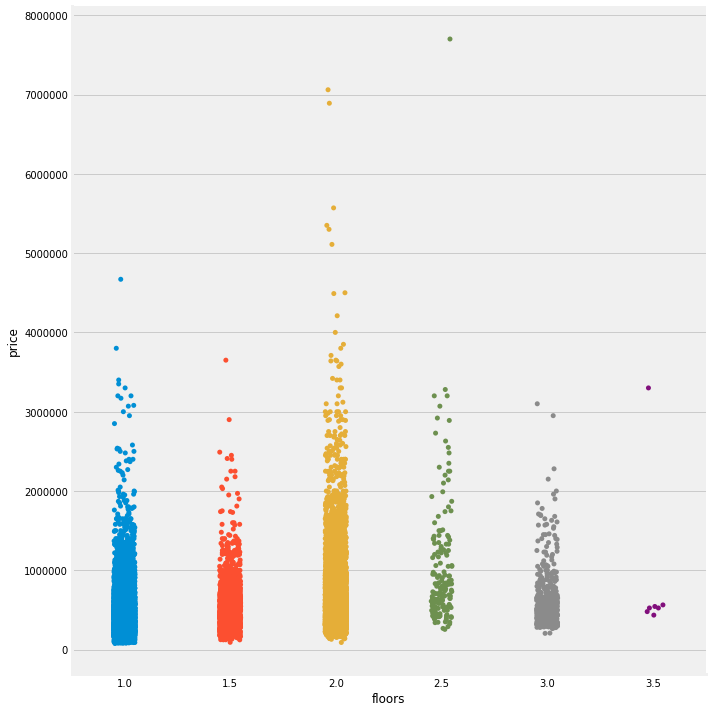

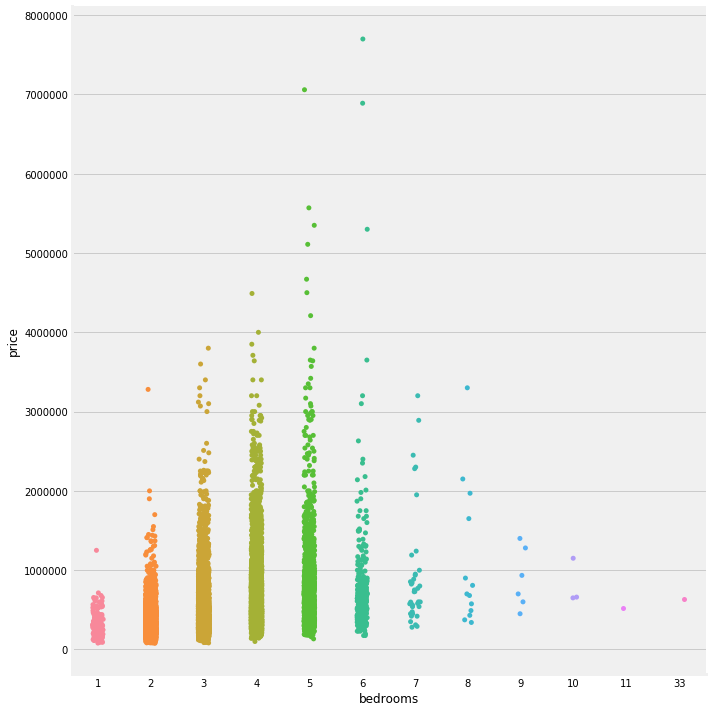

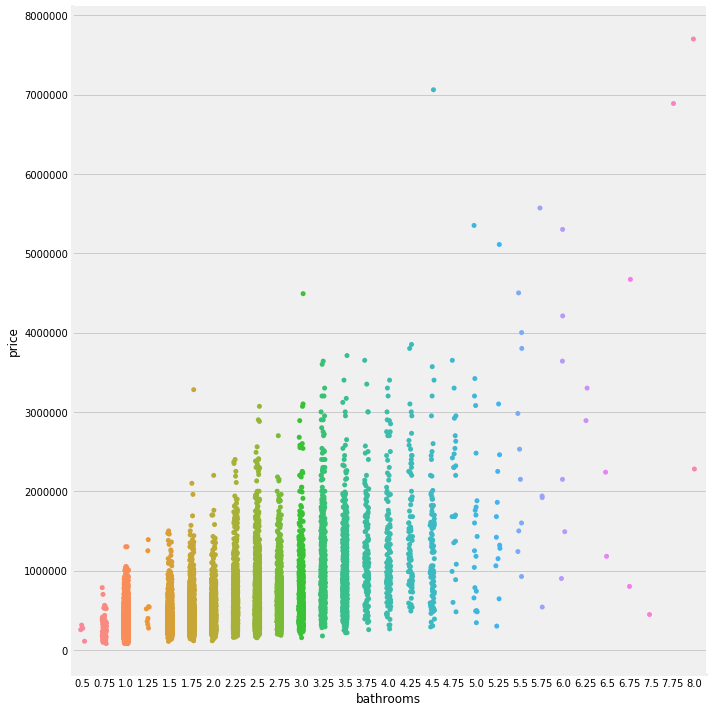

In [44]:
for col in x_cols:
    sns.catplot(x=col, y='price', height=10, legend=True, data=df)

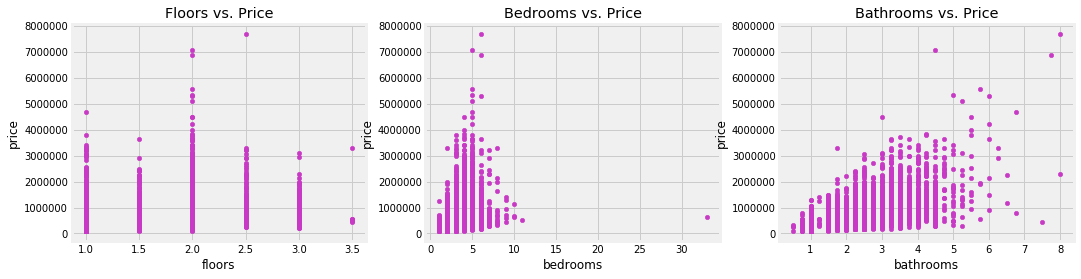

In [30]:
# sub_scatter() creates scatter plots for multiple features side by side.
y = 'price'
x_cols = ['floors','bedrooms', 'bathrooms']

sub_scatter(df, x_cols, y)

Not a significant correlation between bedrooms and price.

In [33]:
# save correlation coefficients higher than 0.5 in a dict
corr_thresh_dict = {}
corrs = ['bathrooms']
corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'bathrooms': 0.5259056214532007}

### ['condition']

In [34]:
hot_stats(df, 'condition', t='price')

-------->
HOT!STATS
<--------

CONDITION
Data Type: int64

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64 

à-la-Mode: 
0    3
dtype: int64


No Nulls Found!

Non-Null Value Counts:
3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

# Unique Values: 5

Correlation with PRICE: 0.0361


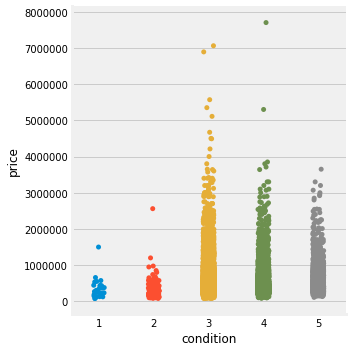

In [35]:
sns.catplot(x='condition', y='price', data=df)

In [36]:
#convert to one-hot enc
df2 = pd.get_dummies(df, columns=['condition'], drop_first=True)

In [37]:
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_waterfront,is_renovated,viewed,basement,condition_2,condition_3,condition_4,condition_5
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,False,False,False,False,0,1,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,False,True,False,True,0,1,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,False,False,False,False,0,1,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,False,False,False,True,0,0,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,False,False,False,False,0,1,0,0


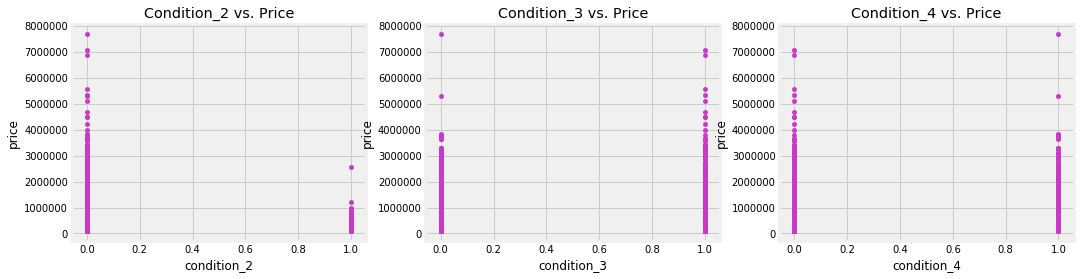

In [38]:
cols = ['condition_2', 'condition_3', 'condition_4']
sub_scatter(df2, cols, 'price')

In [39]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_waterfront', 'is_renovated',
       'viewed', 'basement', 'condition_2', 'condition_3', 'condition_4',
       'condition_5'],
      dtype='object')

In [40]:
groups={}
for col in cols:
    groups[col]= df2.groupby(col)[col,'price'].get_group(1.0)

groups.keys()
groups['condition_2']

,condition_2,price
38,1,240000.0
242,1,455000.0
328,1,186375.0
465,1,80000.0
702,1,480000.0
...,...,...
19284,1,174900.0
19348,1,290000.0
19433,1,450000.0
19496,1,246500.0


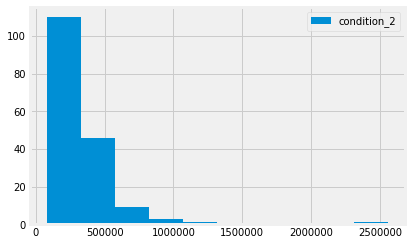

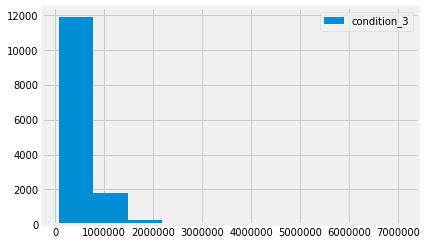

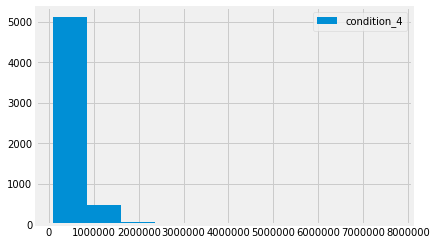

In [42]:
# show diff in subcats
for k, v in groups.items():
    plt.figure()
    plt.hist(v['price'], label=k)
    plt.legend()

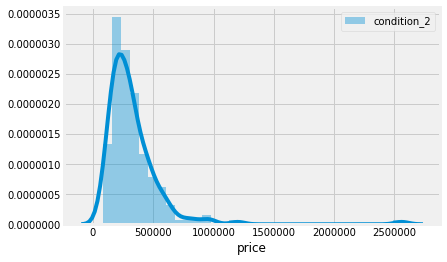

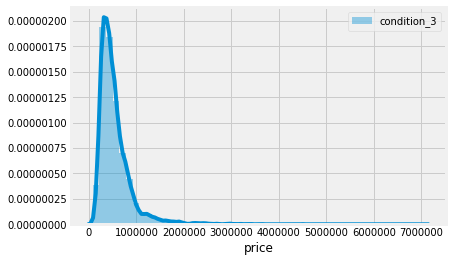

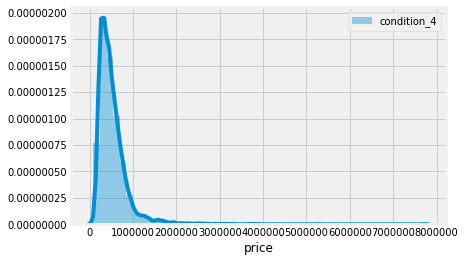

In [43]:
for k, v in groups.items():
    plt.figure()
    sns.distplot(v['price'], label=k)
    plt.legend()

In [ ]:
# diminishing returns

### ['grade']

In [ ]:
# View grade stats
hot_stats(df, 'grade', target='price')

In [ ]:
# Storing correlation vals higher than 0.5 threshold to corr_thresh_dict
corrs = ['bathrooms','grade']

corr_thresh_dict = corr_dict(corrs, 'price')

corr_thresh_dict

In [ ]:
# visualize linearity on a scatter plot
sub_scatter(df, ['condition', 'grade'], 'price', nrows=1, ncols=2)

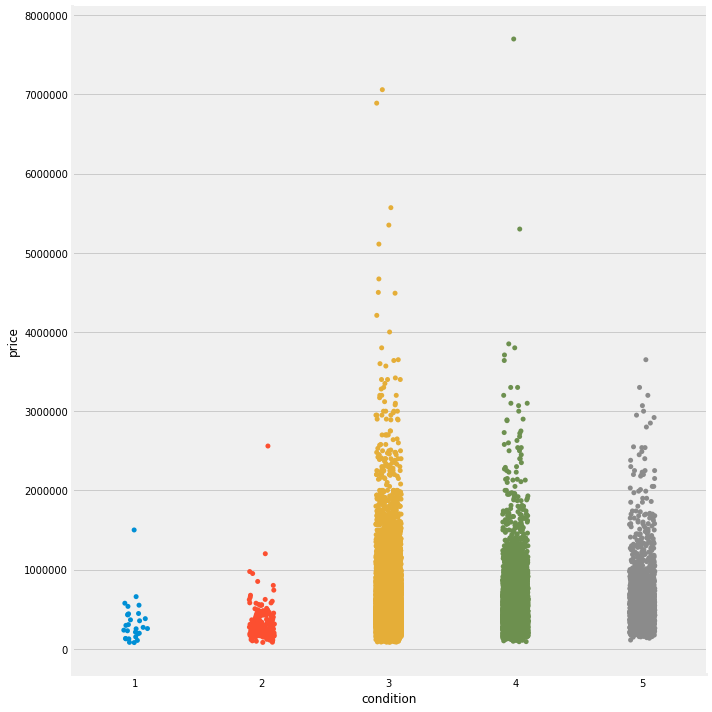

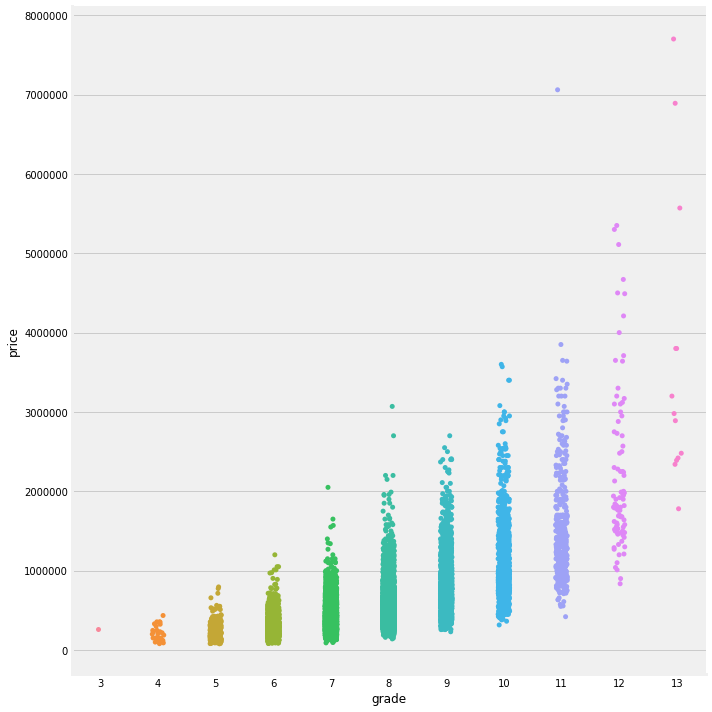

In [45]:
x_cols = ['condition', 'grade']
for col in x_cols:
    sns.catplot(x=col, y='price', height=10, legend=True, data=df)

### ['yr_built'] 

In [48]:
hot_stats(df, 'yr_built', t='price')

-------->
HOT!STATS
<--------

YR_BUILT
Data Type: int64

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64 

à-la-Mode: 
0    2014
dtype: int64


No Nulls Found!

Non-Null Value Counts:
2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

# Unique Values: 116

Correlation with PRICE: 0.054


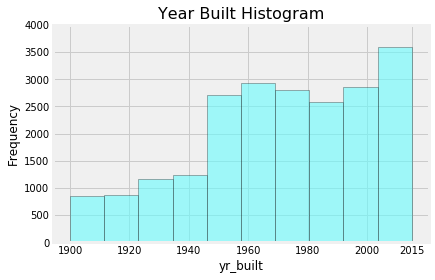

In [49]:
# Let's look at the data distribution of yr_built values 

fig, ax = plt.subplots()
df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
xticks = (1900, 1920, 1940, 1960, 1980, 2000, 2015)
yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
plt.xticks(xticks);
plt.yticks(yticks);
ax.set_title('Year Built Histogram', fontsize=16)
ax.set_xlabel('yr_built', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

Most houses were built during the second half of the century (after 1950). We'll use adaptive binning based on quantiles for yr_built in order to create a more normal distribution.

In [50]:
# define a binning scheme with custom ranges based on quantiles
quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['yr_built'].quantile(quantile_list)

quantiles # 1900, 1951, 1975, 1997, 2015

0.00    1900.0
0.25    1951.0
0.50    1975.0
0.75    1997.0
1.00    2015.0
Name: yr_built, dtype: float64

In [51]:
# Bin the years in to ranges based on the quantiles.
yb_bins = [1900, 1951, 1975, 1997, 2015]

# label the bins for each value 
yb_labels = [1, 2, 3, 4]

# store the yr_range and its corresponding yr_label as new columns in df

# create a new column for the category range values
df['yb_range'] = pd.cut(df['yr_built'], bins=yb_bins)

# create a new column for the category labels
df['yb_cat'] = pd.cut(df['yr_built'], bins=yb_bins, labels=yb_labels)

In [52]:
# view the binned features corresponding to each yr_built 
df[['yr_built','yb_cat', 'yb_range']].iloc[9003:9007] # picking a random index location

,yr_built,yb_cat,yb_range
9003,1996,3,"(1975, 1997]"
9004,1959,2,"(1951, 1975]"
9005,2003,4,"(1997, 2015]"
9006,1902,1,"(1900, 1951]"


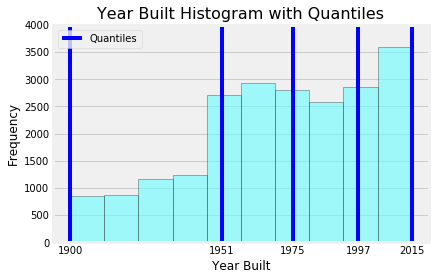

In [53]:
# Let’s look at the original distribution histogram again with the quantiles added:

fig, ax = plt.subplots()

df['yr_built'].hist(bins=10, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='b')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    xticks = quantiles
    yticks = (0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000)
    plt.xticks(xticks);
    plt.yticks(yticks);
    ax.set_title('Year Built Histogram with Quantiles',fontsize=16)
    ax.set_xlabel('Year Built', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

In [54]:
# values look much more normally distributed between the new categories
df.yb_cat.value_counts()

2    5515
3    5411
1    5326
4    5258
Name: yb_cat, dtype: int64

Text(0, 0.5, 'Frequency')

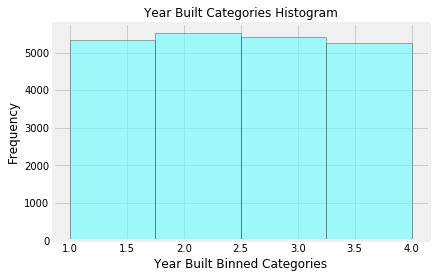

In [55]:
# visualize the distribution of the binned values

fig, ax = plt.subplots()
df['yb_cat'].hist(bins=4, color='#68FDFE', edgecolor='black', grid=True, alpha=0.6)
ax.set_title('Year Built Categories Histogram', fontsize=12)
ax.set_xlabel('Year Built Binned Categories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

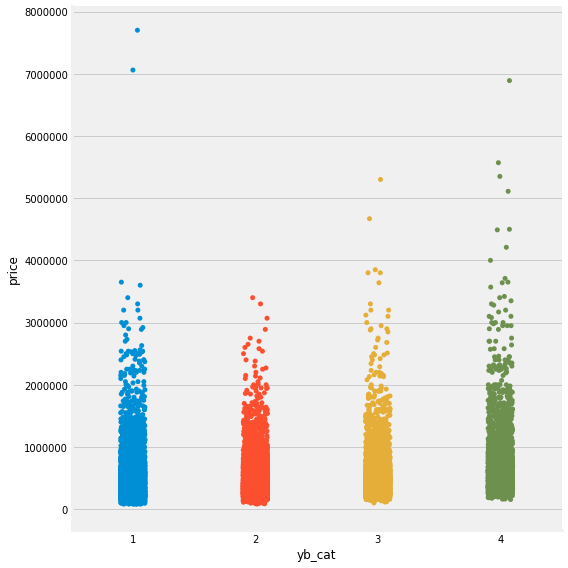

In [58]:
sns.catplot(x='yb_cat', y='price', data=df, height=8)

###  ['zipcode']

In [59]:
hot_stats(df, 'zipcode')

-------->
HOT!STATS
<--------

ZIPCODE
Data Type: int64

count    21597.000000
mean     98077.951845
std         53.513072
min      98001.000000
25%      98033.000000
50%      98065.000000
75%      98118.000000
max      98199.000000
Name: zipcode, dtype: float64 

à-la-Mode: 
0    98103
dtype: int64


No Nulls Found!

Non-Null Value Counts:
98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

# Unique Values: 70



Text(0, 0.5, 'Frequency')

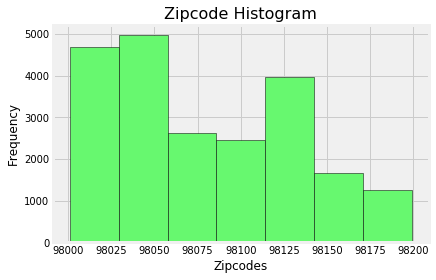

In [60]:
# Let's look at the data distribution of the 70 unique zipcode values 
fig, ax = plt.subplots()
df['zipcode'].hist(bins=7, color='#67F86F',
edgecolor='black', grid=True)
ax.set_title('Zipcode Histogram', fontsize=16)
ax.set_xlabel('Zipcodes', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [61]:
# Let’s define a binning scheme with custom ranges for the zipcode values 
# The bins will be created based on quantiles

quantile_list = [0, .25, .5, .75, 1.]

quantiles = df['zipcode'].quantile(quantile_list)

quantiles # 98001, 98033, 98065, 98118, 98199

0.00    98001.0
0.25    98033.0
0.50    98065.0
0.75    98118.0
1.00    98199.0
Name: zipcode, dtype: float64

In [62]:
# Now we can label the bins for each value and store both the bin range 
# and its corresponding label.

zip_bins = [98000, 98033, 98065, 98118, 98200]

zip_labels = [1, 2, 3, 4]

df['zip_range'] = pd.cut(df['zipcode'], bins=zip_bins)

df['zip_cat'] = pd.cut(df['zipcode'], bins=zip_bins, labels=zip_labels)

# view the binned features 
df[['zipcode','zip_cat', 'zip_range']].iloc[9000:9005] # pick a random index

,zipcode,zip_cat,zip_range
9000,98092,3,"(98065, 98118]"
9001,98117,3,"(98065, 98118]"
9002,98144,4,"(98118, 98200]"
9003,98038,2,"(98033, 98065]"
9004,98004,1,"(98000, 98033]"


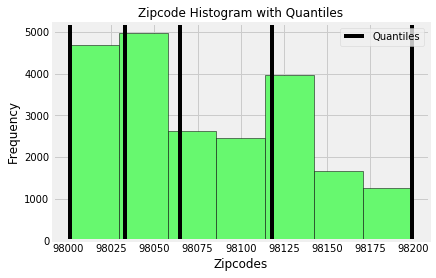

In [63]:
# visualize the quantiles in the original distribution histogram

fig, ax = plt.subplots()

df['zipcode'].hist(bins=7, color='#67F86F', edgecolor='black', grid=True)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='black')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title('Zipcode Histogram with Quantiles',fontsize=12)
    ax.set_xlabel('Zipcodes', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

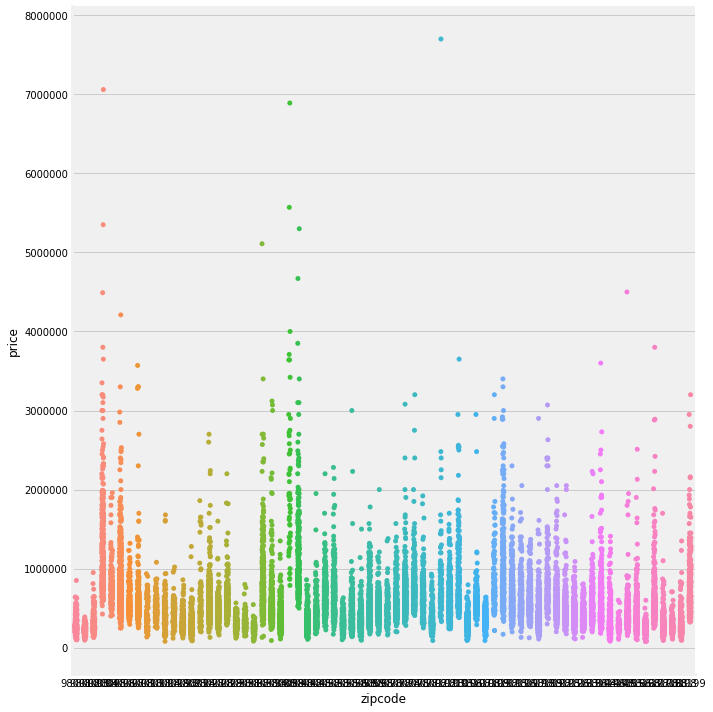

In [66]:
sns.catplot(x='zipcode', y='price', data=df, height=10)

### ['lat']  ['long']

The coordinates for latitude and longitude are not going to be useful to us as far as regression models since we already have zipcodes as a geographic identifier.

### ['date'] 
convert to datetime

In [67]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [68]:
hot_stats(df, 'date', t='price')

-------->
HOT!STATS
<--------

DATE
Data Type: datetime64[ns]

min   2014-05-02
max   2015-05-27
Name: date, dtype: datetime64[ns] 

à-la-Mode: 
0   2014-06-23
dtype: datetime64[ns]


No Nulls Found!

Non-Null Value Counts:
2014-06-23    142
2014-06-25    131
2014-06-26    131
2014-07-08    127
2015-04-27    126
             ... 
2014-07-27      1
2015-03-08      1
2014-11-02      1
2015-05-15      1
2015-05-24      1
Name: date, Length: 372, dtype: int64

# Unique Values: 372



### Continuous

* SQUARE-FOOTAGE

Redundancy check: is there any overlap in the measurements?

* sqft_living = sqft_basement + sqft_above ?
* sqft_lot - sqft_living = sqft_above ?


**Continuous Variables:**
a continuous variable can take on any value within a range

* **sqft_living** --> highest corr : price (before transformation/scaling); most normal distribution
* sqft_lot --> not normal distribution
* sqft_living15 #Highly skewed
* sqft_lot15 #Highly skewed
* sqft_above #High corr with sqft_living
* sqft_basement #Very high number of null values --> treat '0' = no basement?


#### ['sqft_above']

In [70]:
hot_stats(df, 'sqft_above', t='price')

-------->
HOT!STATS
<--------

SQFT_ABOVE
Data Type: int64

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64 

à-la-Mode: 
0    1300
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1300    212
1010    210
1200    206
1220    192
1140    184
       ... 
2601      1
440       1
2473      1
2441      1
1975      1
Name: sqft_above, Length: 942, dtype: int64

# Unique Values: 942

Correlation with PRICE: 0.6054


    Some correlation with price here!

#### ['sqft_living']

In [72]:
hot_stats(df, 'sqft_living', t='price')

-------->
HOT!STATS
<--------

SQFT_LIVING
Data Type: int64

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64 

à-la-Mode: 
0    1300
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1300    138
1400    135
1440    133
1660    129
1010    129
       ... 
4970      1
2905      1
2793      1
4810      1
1975      1
Name: sqft_living, Length: 1034, dtype: int64

# Unique Values: 1034

Correlation with PRICE: 0.7019


    sqft_living shows correlation value of 0.7 with price -- our highest coefficient yet!

In [73]:
# add sqft_living and sqft_above to our correlation threshold dict
corrs = ['sqft_living', 'grade', 'sqft_above', 'bathrooms']
corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'sqft_living': 0.7019173021377598,
 'grade': 0.6679507713876449,
 'sqft_above': 0.6053679437051804,
 'bathrooms': 0.5259056214532007}

#### ['sqft_lot']

In [74]:
hot_stats(df, 'sqft_lot', t='price')

-------->
HOT!STATS
<--------

SQFT_LOT
Data Type: int64

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64 

à-la-Mode: 
0    5000
dtype: int64


No Nulls Found!

Non-Null Value Counts:
5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64

# Unique Values: 9776

Correlation with PRICE: 0.0899


#### ['sqft_living15']

In [75]:
hot_stats(df, 'sqft_living15', t='price')

-------->
HOT!STATS
<--------

SQFT_LIVING15
Data Type: int64

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64 

à-la-Mode: 
0    1540
dtype: int64


No Nulls Found!

Non-Null Value Counts:
1540    197
1440    195
1560    192
1500    180
1460    169
       ... 
4890      1
2873      1
952       1
3193      1
2049      1
Name: sqft_living15, Length: 777, dtype: int64

# Unique Values: 777

Correlation with PRICE: 0.5852


    We've identified another coefficient over the 0.5 correlation threshold.

In [76]:
hot_stats(df, 'sqft_lot15', t='price')

-------->
HOT!STATS
<--------

SQFT_LOT15
Data Type: int64

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64 

à-la-Mode: 
0    5000
dtype: int64


No Nulls Found!

Non-Null Value Counts:
5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64

# Unique Values: 8682

Correlation with PRICE: 0.0828


In [77]:
corrs.append('sqft_living15')

corr_thresh_dict = corr_dict(corrs, 'price')
corr_thresh_dict

{'sqft_living': 0.7019173021377598,
 'grade': 0.6679507713876449,
 'sqft_above': 0.6053679437051804,
 'bathrooms': 0.5259056214532007,
 'sqft_living15': 0.5852412017040661}

### Index

#### ['id']

In [78]:
hot_stats(df, 'id')

-------->
HOT!STATS
<--------

ID
Data Type: int64

count    2.159700e+04
mean     4.580474e+09
std      2.876736e+09
min      1.000102e+06
25%      2.123049e+09
50%      3.904930e+09
75%      7.308900e+09
max      9.900000e+09
Name: id, dtype: float64 

à-la-Mode: 
0    795000620
dtype: int64


No Nulls Found!

Non-Null Value Counts:
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

# Unique Values: 21420



## Duplicates

The primary key we'd use as an index for this data set would be 'id'. Our assumption therefore is that the 'id' for each observation (row) is unique. Let's do a quick scan for duplicate entries to confirm this is true.

In [79]:
# check for duplicate id's
df['id'].duplicated().value_counts() 

False    21420
True       177
Name: id, dtype: int64

In [80]:
# Looks like there are in fact some duplicate ID's! Not many, but worth investigating.

# Let's flag the duplicate id's by creating a new column 'is_dupe':
df.loc[df.duplicated(subset='id', keep=False), 'is_dupe'] = 1 # mark all duplicates 

# verify all duplicates were flagged
df.is_dupe.value_counts() # 353

1.0    353
Name: is_dupe, dtype: int64

In [81]:
# the non-duplicate rows show as null in our new column
df.is_dupe.isna().sum()

21244

In [82]:
# Replace 'nan' rows in is_dupe with 0.0
df.loc[df['is_dupe'].isna(), 'is_dupe'] = 0

# verify
df['is_dupe'].unique()

array([0., 1.])

In [83]:
# convert column to boolean data type
df['is_dupe'] = df['is_dupe'].astype('bool')
# verify
df['is_dupe'].value_counts()

False    21244
True       353
Name: is_dupe, dtype: int64

In [84]:
# Let's now copy the duplicates into a dataframe subset for closer inspection
# It's possible the pairs contain data missing from the other which 
# we can use to fill nulls identified previously.

df_dupes = df.loc[df['is_dupe'] == True]

# check out the data discrepancies between duplicates (first 3 pairs)
df_dupes.head(6)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_wf,is_ren,viewed,basement,yb_range,yb_cat,zip_range,zip_cat,is_dupe
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,False,False,False,True,"(1900, 1951]",1,"(98065, 98118]",3,True
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,False,False,False,True,"(1900, 1951]",1,"(98065, 98118]",3,True
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,False,False,True,True,"(1975, 1997]",3,"(98000, 98033]",1,True
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,False,False,True,True,"(1975, 1997]",3,"(98000, 98033]",1,True
324,7520000520,2014-09-05,232000.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,False,True,False,True,"(1900, 1951]",1,"(98118, 98200]",4,True
325,7520000520,2015-03-11,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,3,6,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,False,True,False,True,"(1900, 1951]",1,"(98118, 98200]",4,True


In [85]:
# Looks like the only discrepancies might occur between 'date' and 'price' values
# Some of the prices nearly double, even when the re-sale is just a few months later!

df_dupes.loc[df_dupes['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_wf,is_ren,viewed,basement,yb_range,yb_cat,zip_range,zip_cat,is_dupe
93,6021501535,2014-07-25,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,False,False,False,True,"(1900, 1951]",1,"(98065, 98118]",3,True
94,6021501535,2014-12-23,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500,False,False,False,True,"(1900, 1951]",1,"(98065, 98118]",3,True


In [86]:
# Set index of df_dupes to 'id'
df_dupes.set_index('id')
# Set index of df to 'id'
df.set_index('id')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_wf,is_ren,viewed,basement,yb_range,yb_cat,zip_range,zip_cat,is_dupe
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,False,False,False,False,"(1951, 1975]",2,"(98118, 98200]",4,False
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,False,True,False,True,"(1900, 1951]",1,"(98118, 98200]",4,False
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,False,False,False,False,"(1900, 1951]",1,"(98000, 98033]",1,False
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,False,False,False,True,"(1951, 1975]",2,"(98118, 98200]",4,False
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,False,False,False,False,"(1975, 1997]",3,"(98065, 98118]",3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,False,False,False,False,"(1997, 2015]",4,"(98065, 98118]",3,False
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,False,False,False,False,"(1997, 2015]",4,"(98118, 98200]",4,False
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,False,False,False,False,"(1997, 2015]",4,"(98118, 98200]",4,False


In [87]:
# Before we drop the duplicates, let's save a backup copy of the current df using pickle.
import pickle
# create pickle data_object
df_predrops = df

In [88]:
with open('data.pickle', 'wb') as f:
    pickle.dump(df_predrops, f, pickle.HIGHEST_PROTOCOL)

In [89]:
#import df (pre-drops) with pickle
#with open('data.pickle', 'rb') as f:
#    df = pickle.load(f)

In [90]:
# let's drop the first occurring duplicate rows and keep the last ones 
# (since those more accurately reflect latest market data)

# save original df.shape for comparison after dropping duplicate rows
predrop = df.shape # (21597, 28)

# first occurrence, keep last
df.drop_duplicates(subset='id', keep ='last', inplace = True) 

# verify dropped rows by comparing df.shape before and after values
print(f"predrop: {predrop}")
print(f"postdrop: {df.shape}")

predrop: (21597, 30)
postdrop: (21420, 30)


## Target

#### ['price']

In [91]:
# Let's take a quick look at the statistical data for our dependent variable (price):
hot_stats(df, 'price')

-------->
HOT!STATS
<--------

PRICE
Data Type: float64

count      21420.00
mean      541861.43
std       367556.94
min        78000.00
25%       324950.00
50%       450550.00
75%       645000.00
max      7700000.00
Name: price, dtype: float64 

à-la-Mode: 
0    450000.0
dtype: float64


No Nulls Found!

Non-Null Value Counts:
450000.0    172
350000.0    167
550000.0    157
500000.0    151
425000.0    149
           ... 
234975.0      1
804995.0      1
870515.0      1
336950.0      1
884744.0      1
Name: price, Length: 3595, dtype: int64

# Unique Values: 3595



Keeping the below numbers in mind could be helpful as we start exploring the data:

* range: 78,000 to 7,700,000
* mean value: 540,296
* median value: 450,000

In [92]:
# At this point we can begin exploring the data. Let's first review our current feature list and get rid
# of any columns we no longer need. As we go through our analysis we'll decide which additional columns to 
# drop, transform, scale, normalize, etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 30 columns):
id               21420 non-null int64
date             21420 non-null datetime64[ns]
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
yr_built         21420 non-null int64
yr_renovated     21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_wf            21420 non-null bool
is_ren           21420 non-nu

In [93]:
# cols to drop bc irrelevant to linreg model or using new versions instead:
hot_drop = ['date','id','waterfront', 'yr_renovated', 'view', 'yr_built', 'yb_range', 'zip_range']

In [94]:
# store hot_drop columns in separate df
df_drops = df[hot_drop].copy()

In [95]:
# set index of df_drops to 'id'
df_drops.set_index('id')
# verify
df_drops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 8 columns):
date            21420 non-null datetime64[ns]
id              21420 non-null int64
waterfront      21420 non-null float64
yr_renovated    21420 non-null float64
view            21420 non-null float64
yr_built        21420 non-null int64
yb_range        21334 non-null category
zip_range       21420 non-null category
dtypes: category(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.2 MB


In [96]:
# drop it like its hot >> df.drop(hot_drop, axis=1, inplace=True)
df.drop(hot_drop, axis=1, inplace=True)

# verify dropped columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 22 columns):
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
is_wf            21420 non-null bool
is_ren           21420 non-null bool
viewed           21420 non-null bool
basement         21420 non-null bool
yb_cat           21334 non-null category
zip_cat          21420 non-null category
is_dupe          21420 non-null bool
dtypes: bool(5), category(2), float64(6), 

In [ ]:
# cols kept for EDA:

# target variable
target = ['price']

# categorical:
cats = ['grade', 'condition', 'zipcode', 'bathrooms', 'bedrooms', 'floors']

#numeric/continuous:
nums = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'sqft_lot15']

# binned:
binned = ['is_waterfront', 'is_renovated', 'viewed', 'is_dupe', 'yb_cat', 'zip_cat', 'bathroom_cat', 'bedroom_cat', 'floor_cat', 'grade_cat',  'condition_cat']

# dummies
dummies = ['condition_2','condition_3', 'condition_4', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6']

In [ ]:
# Create dataframe subsets for each datatype group

df_binned = df[binned]
df_cats = df[cats]
df_nums = df[nums]
#df_dummies = df[dummies]
df_target = df[target]

In [97]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,is_wf,is_ren,viewed,basement,yb_cat,zip_cat,is_dupe
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,False,False,False,False,2,4,False
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,False,True,False,True,1,4,False
2,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,False,False,False,False,1,1,False
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,False,False,False,True,2,4,False
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,False,False,False,False,3,3,False


# EXPLORE:
    
    EDA CHECKLIST:
    linearity (scatter matrices)
    multicollinearity (heatmaps)
    distributions (histograms, KDEs)
    regression (regplot)

**QUESTION: Which features are the best candidates for predicting property values?**
    * Continuous / Numeric Variables
    * Categorical / Discrete Variables
    * Binarized / Binned Variables

## Linearity
During the scrub process we made some assumptions and guesses based on correlation coefficients and other values. Let's see what the visualizations tell us by creating some scatter plots.

In [ ]:
#plt.style.use('seaborn')
# add target to numeric df subset
#df_nums['price'] = df.price

# plot scatter matrix 
#pd.plotting.scatter_matrix(df, y='price', figsize=(20,20));

We can see a clear linear relationship between price and sqft_living, sqft_above, sqft_living15 and somewhat so for sqft_basement. However, it looks like there is covariance among these variables as well.

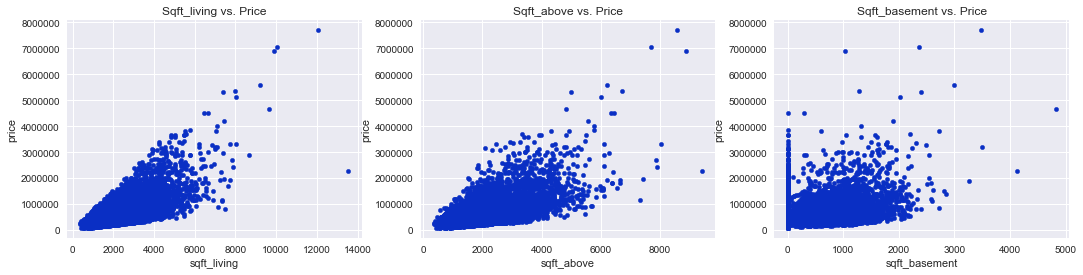

In [101]:
# Visualize the relationship between square-footages and price
sqft_int = ['sqft_living', 'sqft_above', 'sqft_basement']
sub_scatter(df, sqft_int, 'price', color='#0A2FC4') #20C5C6

Linear relationships with price show up clearly for sqft_living, sqft_above, sqft_living15.

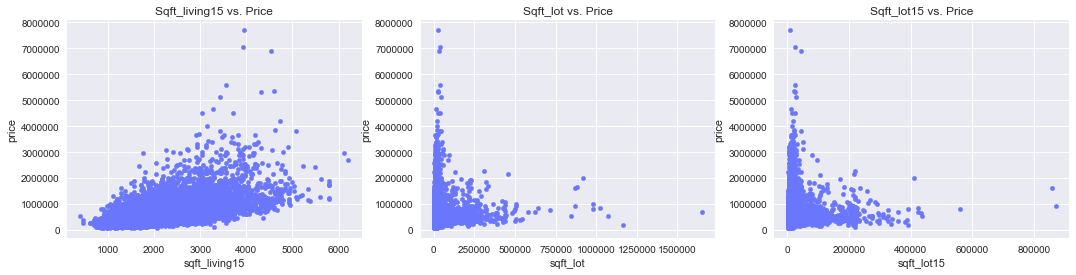

In [102]:
# visualize relationship between sqft_lot, sqft_lot15, sqft_living15 and price.
y = 'price'
x_cols = ['sqft_living15', 'sqft_lot', 'sqft_lot15']

sub_scatter(df, x_cols, y, color='#6A76FB')

## Multicollinearity
**QUESTION: which predictors are closely related (and should be dropped)?**

    + multicollinearity: remove variable having most corr with largest # of variables

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2bf03ef0>)

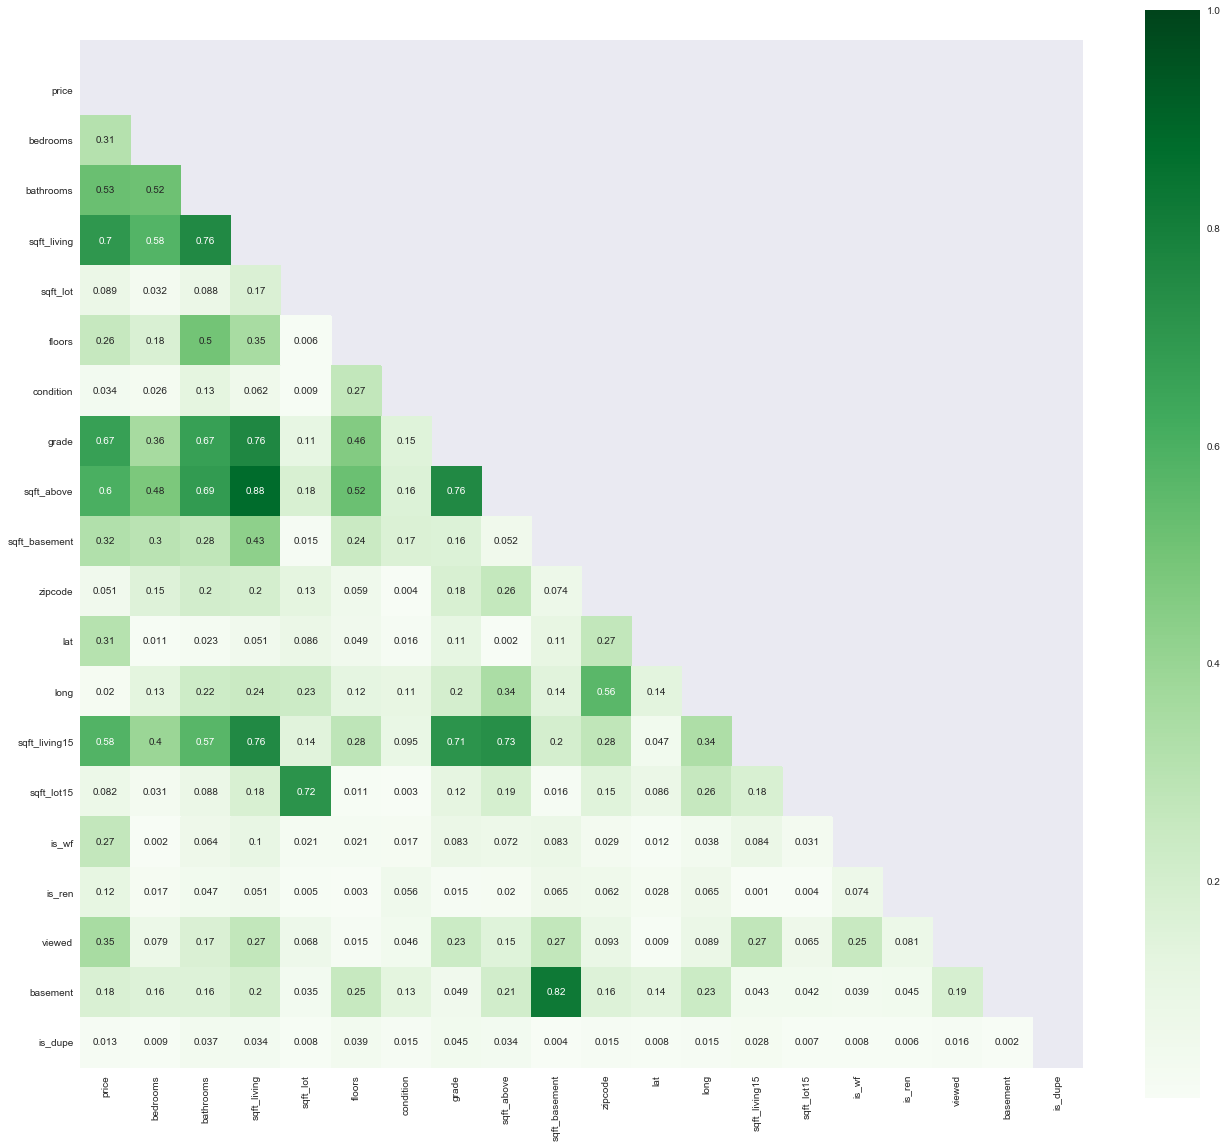

In [104]:
#correlation values to check

corr = df.corr()

# Checking multicollinearity with a heatmap
def multiplot(corr,figsize=(20,20)):
    fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(corr, dtype=np.bool)
    idx = np.triu_indices_from(mask)
    mask[idx] = True

    sns.heatmap(np.abs(corr),square=True,mask=mask,annot=True,cmap="Greens",ax=ax)
    
    ax.set_ylim(len(corr), -.5, .5)
    
    
    return fig, ax

multiplot(np.abs(corr.round(3)))

The square footages probably overlap. (In other words sqft_above and sqft_basement could be part of the total sqft_living measurement).

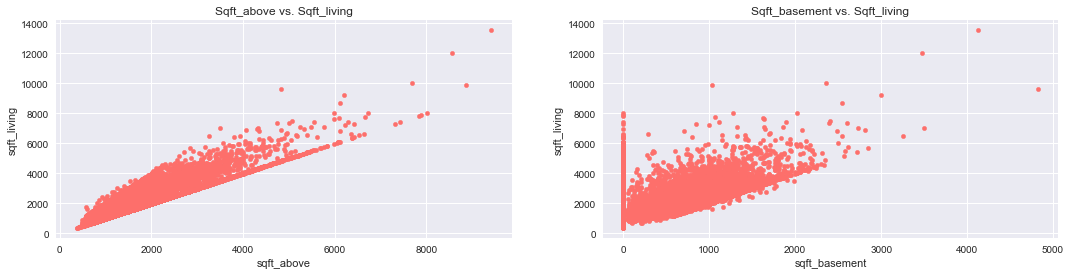

In [105]:
# Visualize multicollinearity between interior square-footages
x_cols = ['sqft_above', 'sqft_basement']
sub_scatter(df, x_cols, 'sqft_living', ncols = 2, color='#FD6F6B')  # lightred

    Yikes. These are extremely linear. Just for fun, let's crunch the numbers...

**QUESTION: Is there any overlap in square-footage measurements?**

In [ ]:
#DataFrame.equals(self, other)	Test whether two objects contain the same elements.

#DataFrame.sum(self[, axis, skipna, level, …])	Return the sum of the values for the requested axis.

In [106]:
# check random location in the index
print(df['sqft_living'].iloc[0]) #1180
print(df['sqft_above'].iloc[0] + df['sqft_basement'].iloc[0]) #1180

print(df['sqft_living'].iloc[1]) #2570
print(df['sqft_above'].iloc[1] + df['sqft_basement'].iloc[1]) #2570

1180
1180.0
2570
2570.0


In [107]:
# sqft_living == sqft_basement + sqft_above ?
# sqft_lot - sqft_living == sqft_above ?

sqft_lv = np.array(df['sqft_living'])
sqft_ab = np.array(df['sqft_above'])
sqft_bs = np.array(df['sqft_basement'])

sqft_ab + sqft_bs == sqft_lv #array([ True,  True,  True, ...,  True,  True,  True])

array([ True,  True,  True, ...,  True,  True,  True])

In [108]:
# check them all at once
if sqft_ab.all() + sqft_bs.all() == sqft_lv.all():
    print("True")

True


**ANSWER: Yes. Sqft_living is the sum of sqft_above and sqft_basement.**

Sqft_living15 (the square-footage of the neighbors' houses) looks to be the only one that correlates well with 
price. However, as we saw above, this also correlates with square-foot living, so we'd run into some multicollinearity issues if we kept both. Since sqft_living is higher, that is likely to be a better candidate 
for prediction.

**QUESTION: Can we combine features for a higher correlation?**

In [109]:
# Correlation coefficient for sqft_living and price
np.corrcoef(df['sqft_living'], df['price'])[0][1]

0.7012948591175869

In [110]:
# Correlation coefficient for sqft_living15 and price
np.corrcoef(df['sqft_living15'], df['price'])[0][1]

0.5837916994556076

In [111]:
# Let's see if we can combine them for a higher correlation

weights = np.linspace(0, 1, 50)

best_weight = 0
max_corr = 0

for weight in weights:
    #creating a new feature by taking a weighted sum
    new_feature = weight*df['sqft_living'] + (1 - weight)*df['sqft_living15']
    
    corr_coef = np.corrcoef(new_feature, df['price'])[0][1]
    if np.abs(corr_coef) > max_corr:
        max_corr = np.abs(corr_coef)
        best_weight = weight
        
print(best_weight, 1 - best_weight)

0.7755102040816326 0.22448979591836737


    The combined correlation value of sqft_living and sqft_living15 (0.77) is indeed higher
    than sqft_living by itself (0.7).

In [112]:
# Let's see if we can also combine bedrooms and bathrooms for a higher correlation

weights = np.linspace(0, 1, 50)

best_weight = 0
max_corr = 0

for weight in weights:
    #creating a new feature by taking a weighted sum
    new_feature = weight*df['bathrooms'] + (1 - weight)*df['bedrooms']
    
    corr_coef = np.corrcoef(new_feature, df['price'])[0][1]
    if np.abs(corr_coef) > max_corr:
        max_corr = np.abs(corr_coef)
        best_weight = weight

print(best_weight, 1 - best_weight)

0.9183673469387754 0.08163265306122458


    0.92 combined correlation for bathrooms and bedrooms!

**ANSWER: We could combine bathrooms/bedrooms as well as sqft_living and sqft_living15 to achieve higher correlation values with price.**
 
...How do we do this?

## Distributions

### Histograms

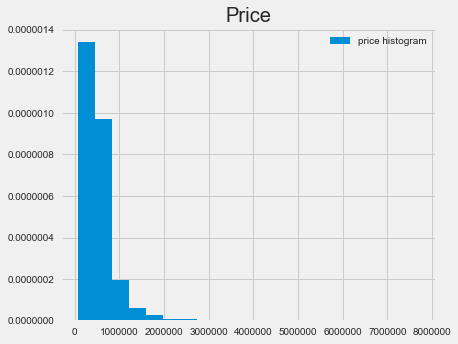

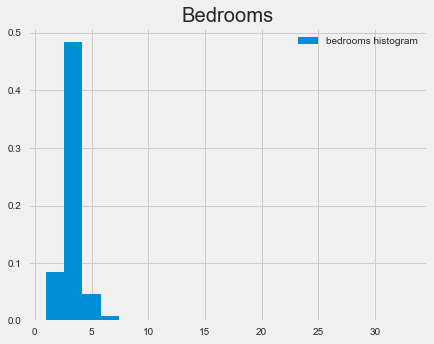

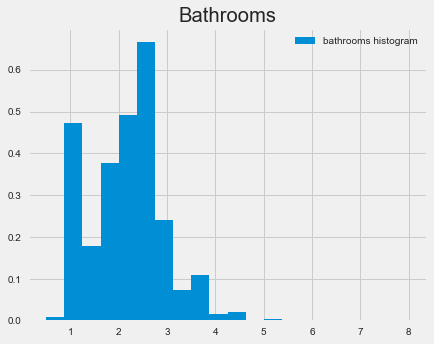

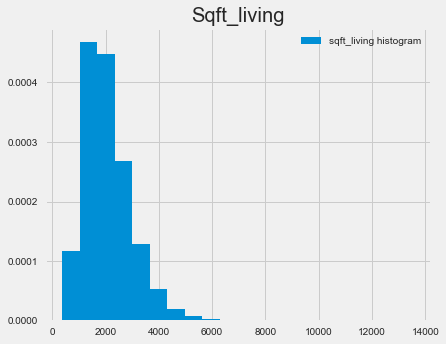

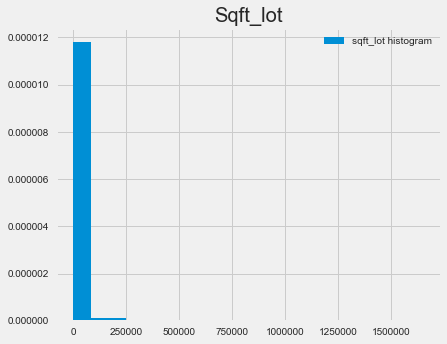

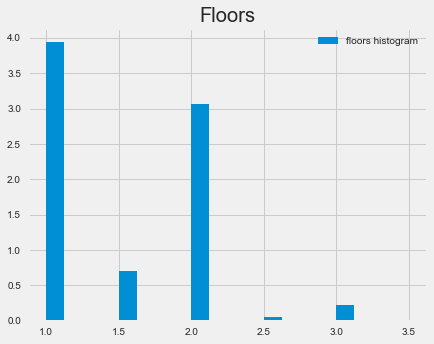

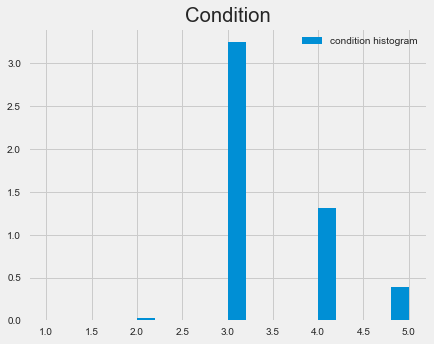

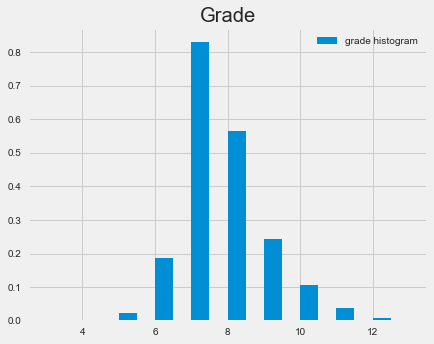

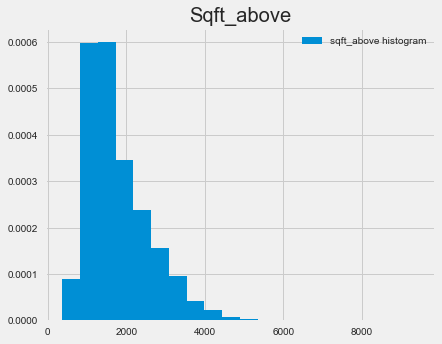

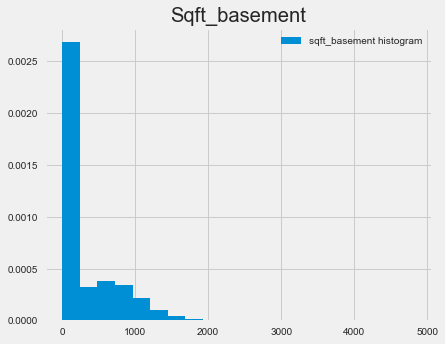

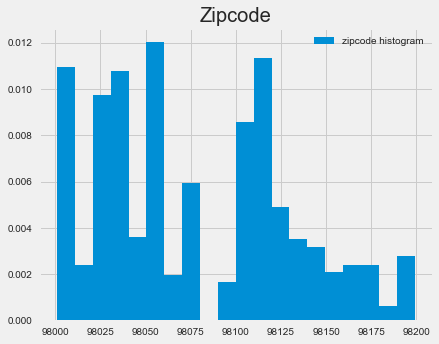

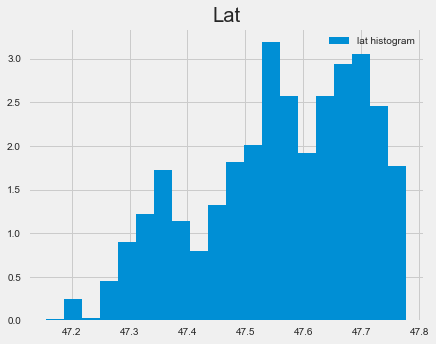

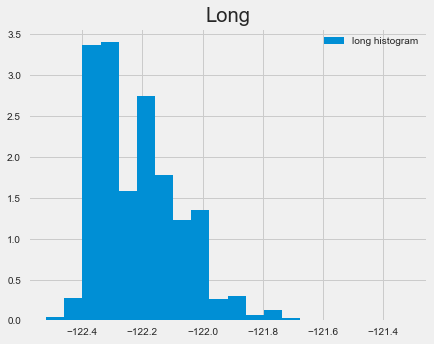

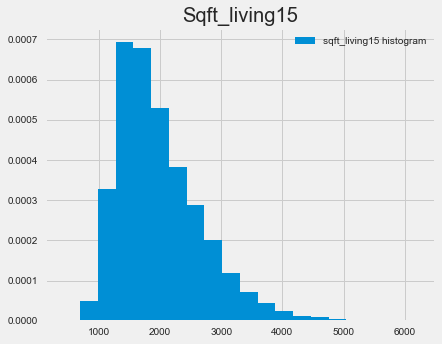

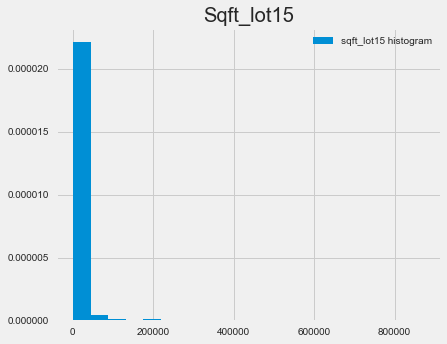

In [120]:
# hist plot
sub_hists(df)

Although sqft_living15 didn't have as much linearity with price as other candidates, it appears to have the most normal distribution out of all of them.

### KDEs

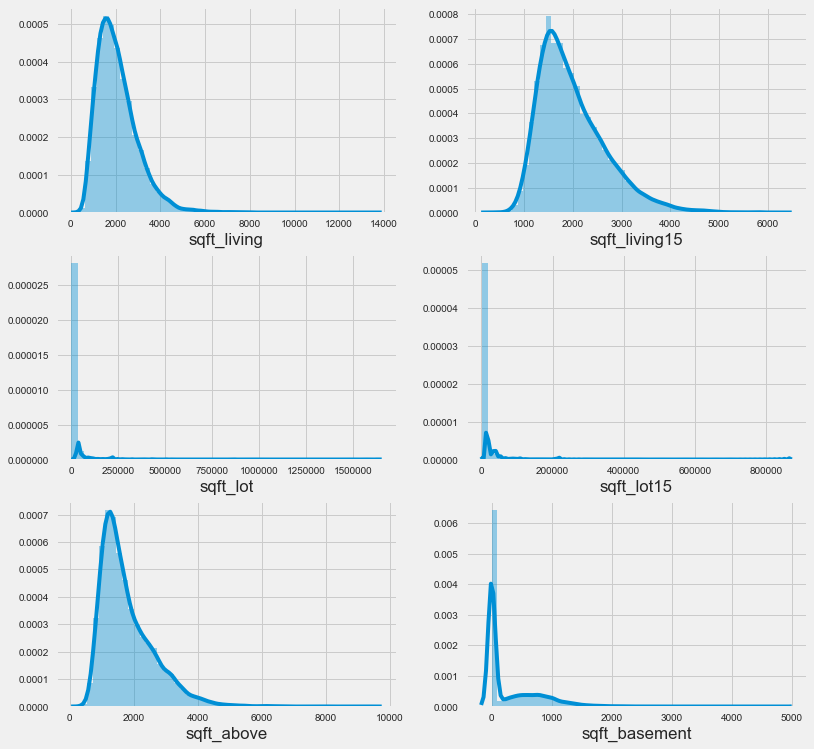

In [121]:
# Kernel Density Estimates (distplots) for square-footage variables
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,12))
sns.distplot(df['sqft_living'], ax=ax[0][0])
sns.distplot(df['sqft_living15'], ax=ax[0][1])
sns.distplot(df['sqft_lot'], ax=ax[1][0])
sns.distplot(df['sqft_lot15'], ax=ax[1][1])
sns.distplot(df['sqft_above'], ax=ax[2][0])
sns.distplot(df['sqft_basement'], ax=ax[2][1])

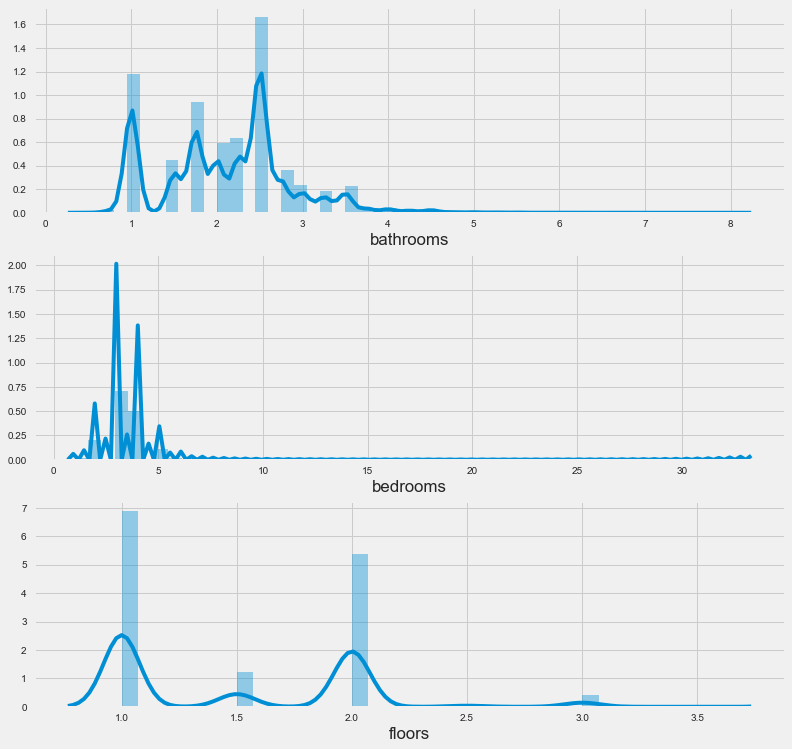

In [123]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12,12))
sns.distplot(df['bathrooms'], ax=ax[0])
sns.distplot(df['bedrooms'], ax=ax[1])
sns.distplot(df['floors'], ax=ax[2])

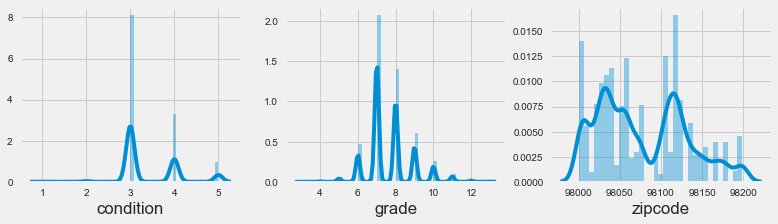

In [131]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
sns.distplot(df['condition'], ax=ax[0])
sns.distplot(df['grade'], ax=ax[1])
sns.distplot(df['zipcode'], ax=ax[2]) # look at actual zipcode value dist instead of category

### Geographic

**QUESTION: Does geography (location) have any relationship with the values of each categorical variable?**

In [ ]:
# bring lat / long columns back in for plotting geographic distribution of ordinal categories

latlong = ['lat', 'long']
latlong_df = df[latlong]
geo_cats_df = pd.concat([df_cats, latlong_df], axis=1)

In [ ]:
# run (ordinal) categorical features through lmplot as a forloop to plot geographic distribution visual

for x in cats:
    sns.lmplot(data=geo_cats_df, x="long", y="lat", fit_reg=False, hue=x, height=10)
plt.show()

    The highest grade properties appear to be most dense in the upper left quadrant. 
    Since we already know that grade has a strong correlation with price, we can 
    posit more confidently that grade, location, and price are all related.
    
    Note: if we were to look at an actual map, we'd see this is Seattle.

In [ ]:
# binary/categorical:
#binned = ['is_waterfront', 'is_renovated', 'viewed', 'is_dupe']

# bring lat / long columns back in for plotting geographic distribution of ordinal categories

geo_bins = pd.concat([df_binned, latlong_df], axis=1)
geo_bins

# run binned features through lmplot as a forloop to plot geographic distribution visual
for x in binned:
    sns.lmplot(data=geo_bins, x="long", y="lat", fit_reg=False, hue=x, height=10)
plt.show()

    Some obvious but also some interesting things to observe in the above lmplots:
    
    The good news is that waterfront properties do indeed show up as being on the water, 
    so we can rest assured that data is valid. Unfortunately as we saw earlier, this doesn't 
    seem to correlate much with price. 
    
    'is_dupe' (which represents properties that sold twice in the 2 year period of this dataset)
    tells us pretty much nothing about anything. At least not on its own here.
    
    Probably the most surprising observation is 'viewed'. They almost all line up with the 
    coastline, or very close to the water. This may not mean anything but it is worth noting.
    
    Lastly, is_renovated is pretty densely clumped up in the northwest quadrant (again, Seattle).
    We can assume therefore that a lot of renovations are taking place in the city. Not entirely
    useful but worth mentioning neverthless.

### Box Plots

In [ ]:
x = df['grade_cat']
y = df['price']

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Grade Categories Boxplot with Outliers'
ax.set_title(title.title())
ax.set_xlabel('grade_cat')
ax.set_ylabel('price')
fig.tight_layout()

In [ ]:
x = df['grade_cat']
y = df['price']

plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) # outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Grade Categories Boxplot - No Outliers'
ax.set_title(title.title())
ax.set_xlabel('grade_cat')
ax.set_ylabel('price')
fig.tight_layout()

In [ ]:
x = df['bathroom_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) # outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bathroom Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bathroom_cat')
ax.set_ylabel('price')
fig.tight_layout()

In [ ]:
x = df['bedroom_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Bedroom Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('bedroom_cat')
ax.set_ylabel('price')
fig.tight_layout()

In [ ]:
x = df['floor_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='large',   
                  rotation=90)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Floor Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('floor_cat')
ax.set_ylabel('price')
fig.tight_layout()

In [ ]:
x = df['zip_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False) #outliers removed

# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='zipcode categories boxplot'
ax.set_title(title.title())
ax.set_xlabel('zip_cat')
ax.set_ylabel('price')
fig.tight_layout()

    Category 3 for zipcode seems to be a good candidate for higher priced homes.

In [ ]:
x = df['yb_cat']
y = df['price']

plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(ncols=1,figsize=(12,6))
sns.boxplot(x=x, y=y, ax=ax, showfliers=False)
# Create keywords for .set_xticklabels()
tick_kwds = dict(horizontalalignment='right', 
                  fontweight='light', 
                  fontsize='x-large',   
                  rotation=45)

ax.set_xticklabels(ax.get_xticklabels(),**tick_kwds)

title='Year Built Categories Boxplot'
ax.set_title(title.title())
ax.set_xlabel('yb_cat')
ax.set_ylabel('price')
fig.tight_layout()

This tells us pretty much nothing other than newer homes sell at a higher price point. Pretty obvious.

## Regression Plots

In [ ]:
plot_reg(df, 'sqft_living', 'price')

In [ ]:
plot_reg(df, 'bathrooms', df.price)

In [ ]:
plot_reg(df, 'grade', df.price)

# FIT AN INITIAL MODEL:

* Assess parameters (slope,intercept)
* Check if the model explains variation in data (RMSE, F, R_square)
* Are the coeffs, slopes, intercepts in appropriate units?
* impact of collinearity? Can we ignore?
* Revise the fitted model
* Multicollinearity is big issue for lin regression and cannot fully remove it
* Use the predictive ability of model to test it (like R2 and RMSE)
* Check for missed non-linearity
* Holdout validation / Train/test split
* use sklearn train_test_split

In [59]:
# features to use list comp
feats = [col for col in df2.columns if 'condition' in col]
feats

['condition_2', 'condition_3', 'condition_4', 'condition_5']

In [60]:
preds = ['C(zipcode)', 'grade', 'sqft_living', 'sqft_living15', 'price']

In [61]:
feats.extend(preds)

In [62]:
feats

['condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'C(zipcode)',
 'grade',
 'sqft_living',
 'sqft_living15',
 'price']

In [63]:
feats.pop()
f1 = '+'.join(feats)

In [64]:
f ='price~'+f1

In [65]:
model =smf.ols(formula=f, data=df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     851.7
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:55:15   Log-Likelihood:            -2.9240e+05
No. Observations:               21597   AIC:                         5.850e+05
Df Residuals:                   21520   BIC:                         5.856e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.738e+05   3.66e+04    -15.662      0.000   -6.46e+05   -5.02e+05
C(zipcode)[T.98002]  4.035e+04   1.63e+04      2.479      0.013    8451.287    7.22e+04
C(zipcode)[T.98003] -9151.0479   1.46e+04     -0.625      0.532   -3.79e+04    1.96e+04
C(zipcode)[T.98004]   7.68e+05   1.43e+04     53.671      0.000     7.4e+05    7.96e+05
C(zipcode)[T.98005]  2.758e+05   1.73e+04     15.948      0.000    2.42e+05     3.1e+05
C(zipcode)[T.98006]  2.572e+05   1.29e+04     19.870      0.000    2.32e+05    2.83e+05
C(zipcode)[T.98007]  2.226e+05   1.83e+04     12.162      0.000    1.87e+05    2.58e+05
C(zipcode)[T.98008]  2.817e+05   1.46e+04     19.258      0.000    2.53e+05     3.1e+05
C(zipcode)[T.98010]  8.014e+04   2.08e+04      3.856      0.000    3.94e+04    1.21e+05
C(zipcode)[T.98011]  1.041e+05   1.64e+04      6.360      0.000     7.2e+04    1.36e+05
C(zipcode)[T.98014]  1.317e+05   1.91e+04      6.881      0.000    9.42e+04    1.69e+05
C(zipcode)[T.98019]  8.082e+04   1.65e+04      4.898      0.000    4.85e+04    1.13e+05
C(zipcode)[T.98022]  4.119e+04   1.55e+04      2.662      0.008    1.09e+04    7.15e+04
C(zipcode)[T.98023] -3.471e+04   1.27e+04     -2.729      0.006   -5.96e+04   -9782.302
C(zipcode)[T.98024]  1.931e+05   2.27e+04      8.494      0.000    1.49e+05    2.38e+05
C(zipcode)[T.98027]  1.467e+05   1.33e+04     11.017      0.000    1.21e+05    1.73e+05
C(zipcode)[T.98028]  1.135e+05   1.46e+04      7.766      0.000    8.48e+04    1.42e+05
C(zipcode)[T.98029]  1.871e+05   1.42e+04     13.196      0.000    1.59e+05    2.15e+05
C(zipcode)[T.98030] -4173.6835    1.5e+04     -0.278      0.781   -3.36e+04    2.53e+04
C(zipcode)[T.98031]  1058.9730   1.48e+04      0.072      0.943   -2.79e+04       3e+04
C(zipcode)[T.98032]  6186.7626   1.91e+04      0.324      0.746   -3.12e+04    4.36e+04
C(zipcode)[T.98033]  3.672e+05   1.32e+04     27.908      0.000    3.41e+05    3.93e+05
C(zipcode)[T.98034]  2.095e+05   1.25e+04     16.790      0.000    1.85e+05    2.34e+05
C(zipcode)[T.98038]  1.756e+04   1.23e+04      1.426      0.154   -6570.444    4.17e+04
C(zipcode)[T.98039]  1.341e+06   2.79e+04     47.984      0.000    1.29e+06     1.4e+06
C(zipcode)[T.98040]  5.332e+05   1.49e+04     35.833      0.000    5.04e+05    5.62e+05
C(zipcode)[T.98042] -3550.9813   1.25e+04     -0.285      0.776    -2.8e+04    2.09e+04
C(zipcode)[T.98045]  1.107e+05   1.57e+04      7.035      0.000    7.98e+04    1.42e+05
C(zipcode)[T.98052]  2.062e+05   1.24e+04     16.603      0.000    1.82e+05    2.31e+05
C(zipcode)[T.98053]  1.908e+05   1.34e+04     14.225      0.000    1.64e+05    2.17e+05
C(zipcode)[T.98055]  5.688e+04   1.48e+04      3.837      0.000    2.78e+04    8.59e+04
C(zipcode)[T.98056]  9.832e+04   1.33e+04      7.379      0.000    7.22e+04    1.24e+05
C(z

In [ ]:

# Enter equation for selected predictors: (use C to run as categorical)
f1 = 'price~C(zipcode)+C(grade)+sqft_living+sqft_living15'
# Run model and report sumamry
model = smf.ols(formula=f1, data=df_pred).fit()
model.summary()

R-squared value: 0.78 - Not bad! But Kurtosis and Skew are less than ideal...

In [ ]:
# Check normalized values with historgrams and scatter

## Outliers

**QUESTION: Does removing outliers improve the distribution?**

## Scaling / Normalization

The dataset's remaining features vary significantly in magnitude which will throw off the R2 coefficient (essentially giving the false impression that some variables are less important).

In [66]:
# ADDING OUTLIER REMOVAL FROM preprocessing.RobuseScaler
from sklearn.preprocessing import RobustScaler

robscaler = RobustScaler()
robscaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [68]:
# good to use when you have outliers 
# uses median 

In [69]:
scaled_vars = ['sqft_living','sqft_lot','sqft_living15','sqft_lot15','bedrooms','bathrooms']
df_scaled = df[scaled_vars]

In [70]:
for col in scaled_vars:
    col_data = df_scaled[col].values
    #col_data = np.array(np.array(df_scaled[col]))
    res = robscaler.fit_transform(col_data.reshape(-1,1)) # don't scale target
    df_scaled['sca_'+col] = res.flatten()

In [73]:
df_scaled.describe().round(3)

# sca_sqft_lot

# df_scaled.loc[df[]]

,sqft_living,sqft_lot,sqft_living15,sqft_lot15,bedrooms,bathrooms,sca_sqft_living,sca_sqft_lot,sca_sqft_living15,sca_sqft_lot15,sca_bedrooms,sca_bathrooms
count,21597.000,21597.000,21597.00,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,2080.322,15099.409,1986.62,12758.284,3.373,2.116,0.152,1.325,0.169,1.031,0.373,-0.179
std,918.106,41412.637,685.23,27274.442,0.926,0.769,0.820,7.336,0.788,5.473,0.926,1.025
min,370.000,520.000,399.00,651.000,1.000,0.500,-1.375,-1.257,-1.656,-1.399,-2.000,-2.333
25%,1430.000,5040.000,1490.00,5100.000,3.000,1.750,-0.429,-0.457,-0.402,-0.506,0.000,-0.667
50%,1910.000,7618.000,1840.00,7620.000,3.000,2.250,0.000,0.000,0.000,0.000,0.000,0.000
75%,2550.000,10685.000,2360.00,10083.000,4.000,2.500,0.571,0.543,0.598,0.494,1.000,0.333
max,13540.000,1651359.000,6210.00,871200.000,33.000,8.000,10.384,291.185,5.023,173.305,30.000,7.667


In [75]:
scales = [col for col in df_scaled.columns if col.startswith('sca_')]
scales

['sca_sqft_living',
 'sca_sqft_lot',
 'sca_sqft_living15',
 'sca_sqft_lot15',
 'sca_bedrooms',
 'sca_bathrooms']

### One-Hot Encoding



In [ ]:
# get_dummies for one-hot encoding
yb_dummies = pd.get_dummies(df['yb_cat'], prefix='yb', drop_first=True)
df = pd.concat([df, yb_dummies], axis=1)
df.head(2)


# get_dummies for one-hot encoding
zip_dummies = pd.get_dummies(df['zip_cat'], prefix='zip', drop_first=True)
# drop first dummy to avoid multicollinearity trap
df = pd.concat([df, zip_dummies], axis=1)
# inspect
df.head()

### Log Transformation

Reduces skewness and variability of data to improve regression algorithm.

In [ ]:
# Log Transform

#x = np.linspace(start=-100, stop=100, num=10**3)
#y = np.log(x)
#plt.plot(x,y)

# Make data more normal (improve skewness)

#data_log = pd.DataFrame([])
#data_log['log_sqftliv'] = np.log(df_pred['sqft_living'])
#data_log['log_bathrooms'] = np.log(df_pred['bathrooms'])
#data_log['log_grade'] = np.log(df_pred['grade'])

### MinMax Scaling

Reduces skewness and variability of data to improve regression algorithm.

In [ ]:
# create empty dataframe for scaled features
data_cont_scaled = pd.DataFrame([])

# minmax scaling on sqft_living:
sqftliv = df_pred['sqft_living']
scaled_sqftliv = (sqftliv - min(sqftliv)) / (max(sqftliv) - min(sqftliv))
data_cont_scaled['sqftliv'] = scaled_sqftliv

In [ ]:
# This did nothing...let's try standardization
#minmax scaling on grade

#grade = df_pred['grade']
#scaled_grade = (grade - min(grade)) / (max(grade) - min(grade))
#data_cont_scaled['grade'] = scaled_grade

# minmax scaling on bathrooms
#bathrooms = df_pred['bathrooms']
#scaled_bathrooms = (bathrooms - min(bathrooms)) / (max(bathrooms) - min(bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms

# This did nothing... let's try mean normalization

#log_grade = data_log['log_grade']
#scaled_grade = (log_grade - np.mean(log_grade)) / np.sqrt(np.var(log_grade))
#data_cont_scaled['grade'] = scaled_grade


#log_bathrooms = data_log['log_bathrooms']
#scaled_bathrooms = (log_bathrooms - np.mean(log_bathrooms)) / np.sqrt(np.var(log_bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms


# This did nothing...probably because they're categorical?
# mean normalization
#log_grade = data_log['log_grade']
#scaled_grade = (log_grade - np.mean(log_grade)) / (max(log_grade) - min(log_grade))
#data_cont_scaled['grade'] = scaled_grade

#log_bathrooms = data_log['log_bathrooms']
#scaled_bathrooms = (log_bathrooms - np.mean(log_bathrooms)) / (max(log_bathrooms) - min(log_bathrooms))
#data_cont_scaled['bathrooms'] = scaled_bathrooms


In [ ]:
df_pred['zip'] = df_drops['zipcode']
df_pred['bath'] = df_drops['bathrooms']
df_pred['grade'] = df_drops['grade']
df_pred['zip'] = df_pred['zip'].astype('category')
df_pred['bath'] = df_pred['bath'].astype('category')
df_pred['grade'] = df_pred['grade'].astype('category')

In [ ]:
data_cont_scaled.hist(figsize=(6,6))

In [ ]:
# NOPE this just created a bunch of NaNs for grade and bathroom

# create a new dataframe and add dummy_vars
data_fin = pd.DataFrame([])
data_fin['sqftliv'] = scaled_sqftliv
#grade_dummies = pd.get_dummies(df_pred['grade'], prefix='grade')
#bathroom_dummies = pd.get_dummies(df_pred['bathrooms'], prefix='bath')
#zip_dummies = pd.get_dummies(df_pred['zip'], prefix='zip')
data_fin['grade'] = scaled_grade
data_fin['bath'] = scaled_bathrooms
price = df_pred['price']
data_fin = pd.concat([price, data_fin], axis=1)
data_fin


In [ ]:
# Run OLS on data using formula y~X where w n predictors X is x, + x1 + ... xn
import statsmodels.api as sm
from statsmodels.formula.api import ols
outcome = 'price'
predictors = data_fin.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=data_fin).fit()
model.summary()

## Stepwise Selection
Start with empty model, find lowest p-value and perform a forward-backward feature selection based on pvalue

## Forward Selection

In [ ]:
# Choose a linear model by forward selection
# The function below optimizes adjusted R-squared by adding features that help the most one at a time
# until the score goes down or you run out of features.

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
model = forward_selected(df_pred, 'price')
print(model.model.formula)
print(model.rsquared_adj)

In [ ]:
model = forward_selected(df_pred, 'price')
print(model.model.formula)
print(model.rsquared_adj)

Explaining/Phrasing R-Squared values
An obtained R-squared value of say 0.85 can be put into a statement as

85% of the variations in dependent variable  𝑦  are explained by the independent variable in our model.

In [ ]:
# RFE Recursive Feature Selection

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics



# Define selector function combining RFE and linear regression
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=1)

# Drop target variable
X = df_pred.drop('price',axis=1)

# RUNNING RFE ON THE UNSCALED DATA(DEMONSTRATION)
Y = df_pred['price']
# Y = df_run['logz_price']
# X = df_run.drop(['price'],axis=1)


# Run regressions on X,Y 
selector = selector.fit(X,Y)

# Saving unscaled rankings for demo purposes
no_scale = selector.ranking_




# Scale all variables to value between 0-1 to use RFE to determine which features are the most important for determining price?
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale the data before running RFE

# dummy vars zip?


# ONLY SCALE NON-CATEGORICAL, ONE-HOT CATEGORICAL
scaler.fit(X,Y)
scaled_data = scaler.transform(X)
scaled_data.shape

In [ ]:
# Running RFE with scaled data
selector = selector.fit(scaled_data, Y) 
scaled = selector.ranking_
type(scaled)


# Create a dataframe with the ranked values of each feature for both scaled and unscaled data
best_features = pd.DataFrame({'columns':X.columns, 'scaled_rank' : scaled,'unscaled_rank':no_scale})
best_features.set_index('columns',inplace=True)


# Display dataframe (sorted based on unscaled rank)
best_features.sort_values('unscaled_rank')

# FINAL MODEL

## OLS Multivariate Regression

DETERMINING IDEAL FEATURES TO USE
Use MinMaxScaler to get on same scale
Use RFE to find the best features

In [ ]:
# save final output
# df_final_data.to_csv(data_filepath+'kc_housing_model_df_final_data.csv')

# VALIDATION

## K-Fold Validation with OLS

In [ ]:
resid1=model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True,marker='.')

# Visualizations

In [ ]:
# pypi package for retrieving information based on us zipcodes
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database

zipcodes = df['zipcode'].unique()

dzip= {}

for c in zipcodes:
    z = search.by_zipcode(c)
    dzip[c] = z.to_dict()
    
dzip.keys()


dzip[98001]['median_home_value']



med_home_vals = []
zips = []

for index in dzip:
    med_home_vals.append(dzip[index]['median_home_value'])

for index in dzip:
    zips.append(dzip[index]['zipcode'])

dzip_mhv = dict(zip(zips, med_home_vals))

In [ ]:
colormap = ('skyblue', 'salmon', 'lightgreen')
plt.figure()
pd.plotting.parallel_coordinates(df, 'price', cols=['sqft_living', 'grade_cat', 'zip_cat', 'bathroom_cat'], color=colormap);
pd.plotting.parallel_coordinates
#pd.plotting.scatter_matrix(df);

In [ ]:
import plotly.graph_objects as go

import pandas as pd

#df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(range = [32000,227900],
                 constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()

##### TABLEAU HOW TO (temp)
Short how-to plot geo data in Tableau:
Load in your .csv dataset from your project.
Let it use data interpreter. It should identify zipcode as a location.
On your worksheet page:
For plotting each price for each house:
Drag the Measures Lat and Long onto the rows and columns boxes (top of sheet)
Drag the Measure price onto the Color Button under Marks.
It should now be listed at the bottom of the Marks panel.
Right-click and select "Dimension"
For plotting median income by zipcode:
Drag zipcode form the Dimensions panel onto the main graph window.
It will automatically load in map of location.
Drag price onto the color button (it will now appear in the Marks window)
Rich click on Price. Select "Measure" > Median
Customize map features by selecting "Map" > Map Layers on the Menu Bar.


In [ ]:
# https://www.youtube.com/watch?v=upBvuTqOy9k&feature=youtu.be

import plotly
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [ ]:
data = go.Scatter(x=[1,2,3,4], y=[3,6,8,9], name='Blue')
layout = go.Layout(title='Random Scatter')

fig = go.Figure(data=data, layout=layout)

* "how did you pick the question(s) that you did?"
* "why are these questions important from a business perspective?"
* "how did you decide on the data cleaning options you performed?"
* "why did you choose a given method or library?"
* "why did you select those visualizations and what did you learn from each of them?"
* "why did you pick those features as predictors?"
* "how would you interpret the results?"
* "how confident are you in the predictive quality of the results?"
* "what are some of the things that could cause the results to be wrong?"

## DATE

In [ ]:
# group data by dates/months/years to explore comparison in market fluctuations

print(df.date.min())
print(df.date.max())

# Our dataset contains values spanning two years: beginning May 2014 to end of May 2015

In [ ]:
df.date.dt.year.value_counts(normalize=True)
# 2014    14622
# 2015     6975
# The majority of our data (67%) is from 2014

In [ ]:
df.date.dt.month.value_counts()

### Impact of date (month or year) on price
Question: are housing prices lower or higher in certain months (better to buy)?

In [ ]:
# create new columns for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# There does not appear to be any correlation whatsoever with 
weights = np.linspace(0,1)
np.corrcoef(df['month'], df['price'])
np.corrcoef(df['year'], df['price'])

In [ ]:
df.month.value_counts(normalize=True)

In [ ]:
# create variables for each series you want to pass into the xcols list and compare them against one
y_sub = 'price'
date_sub = ['year','month']

sub_scatter(date_sub, y_sub)

In [ ]:
# check data discrepancies between duplicates (if any):

# 1 - compare price (house value) and date of sale:

# dupes         date        price
# 6021501535   12/23/2014   700,000
#               7/25/2014   430,000
    
# 4139480200   12/9/2014
# 7520000520   3/11/2015
# 3969300030   12/29/2014
# 2231500030   3/24/2015



#for df['id'] in df:
#    if df['id'] == 
#        print(f"{df.id} : {date} : {price}\n")
     #  4139480200
#dupes_id = dupes['id']
#dupes_price = dupes['price']

# 2 - compare other discrepancies and/or missing values 

In [ ]:
DataFrame.to_period(self[, freq, axis, copy])	Convert DataFrame from DatetimeIndex to PeriodIndex with desired frequency (inferred from index if not passed).